In [126]:
# local에 padnas, numpy, matplotlib 설치필요
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from surprise import SVD, Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import seaborn as sns

# 1. Amazon Data

**1-1. Used Data**

*   https://amazon-reviews-2023.github.io/






In [127]:
categories = [
    "Electronics",
    "Movies_TV",
    "Sports_Outdoors",
    "Video_Games",
    "Software",
    "Fashion",
    "Grocery_Gourmet_Food",
    "Car",
    "Beauty",
    "Music"
    ]

# Colaborative Filtering

전체 상품에 대한 CF

In [128]:
def preprocess_review(review_path, min_user_cnt, min_review_cnt):
    try:
        review_df = pd.read_json(review_path, lines=True)
        filtered_review_df = review_df[["parent_asin", "rating", "user_id", "title", "category", "product_title"]]
        # filtered_review_df = filtered_review_df[filtered_review_df["category"] == category]
        distinct_review_df = filtered_review_df.drop_duplicates(subset=["user_id", "parent_asin"])
        
        review_counts = distinct_review_df["parent_asin"].value_counts()
        user_counts = distinct_review_df['user_id'].value_counts()
        
        result_df = distinct_review_df[(
            (distinct_review_df['user_id'].isin(user_counts[user_counts >= min_user_cnt].index)) &
            (distinct_review_df['parent_asin'].isin(review_counts[review_counts >= min_review_cnt].index))
        )]
        return result_df
    except Exception as e:
        print(f"Error in preprocess_review: {e}")
        raise

In [129]:
# 데이터 준비
def prepare_data(df):
    reader = Reader(rating_scale=(1, 5))  # 평점 범위 지정
    data = Dataset.load_from_df(df[["user_id", "parent_asin", "rating"]], reader)
    return data

def coverage(predictions, total_len):
    recommended_items = set([pred.iid for pred in predictions])
    return len(recommended_items) / total_len

# 모델 학습 및 평가
def knn_based_cf(df,org_df):
    # Surprise 데이터 준비
    data = prepare_data(df)
    
    # 훈련 및 테스트 데이터 분리
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    
    # 코사인 유사도를 사용한 아이템 기반 CF 모델 설정
    sim_options = {
        "name": "cosine",  # 코사인 유사도
        "user_based": False,  # 아이템 기반
    }
    algo = KNNBasic(sim_options=sim_options)
    
    # 모델 훈련
    algo.fit(trainset)
    
    # 테스트 데이터로 예측
    predictions = algo.test(testset)
    
    # RMSE 계산
    rmse = accuracy.rmse(predictions)
    
    # Coverage 계산
    total_len = len(org_df['parent_asin'].unique())
    coverage_value = coverage(predictions, total_len)
     
    
    return rmse,coverage_value

# 실행
review_path = os.path.abspath("./Data/Amazon/Review/combined_data2.json")
review_df = pd.read_json(review_path, lines=True)
raw_df = review_df[["parent_asin", "rating", "user_id", "title", "category", "product_title"]]
raw_df = raw_df.drop_duplicates(subset=["user_id", "parent_asin"])

review_df = preprocess_review(review_path,2,1)
 
# 아이템 기반 CF 실행
rmse,coverage_value = knn_based_cf(review_df,raw_df)
print("KNN based")
print(f"RMSE: {rmse:.3f}")
print(f"Coverage: {coverage_value:.2%}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2468
KNN based
RMSE: 1.247
Coverage: 18.66%


In [130]:
# 데이터 준비
def prepare_data(df):
    reader = Reader(rating_scale=(1, 5))  # 평점 범위 지정
    data = Dataset.load_from_df(df[["user_id", "parent_asin", "rating"]], reader)
    return data

# SVD 기반 추천 시스템
def svd_based_cf(df,org_df):
    # Surprise 데이터 준비
    data = prepare_data(df)
    
    # 훈련 및 테스트 데이터 분리
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    
    # SVD 모델 설정
    algo = SVD(n_factors=50, random_state=42)  # 잠재 요인 개수 설정
    
    # 모델 학습
    algo.fit(trainset)
    
    # 테스트 데이터로 예측
    predictions = algo.test(testset)
    
    # RMSE 계산
    rmse = accuracy.rmse(predictions)
    
    # Coverage 계산
    total_len = len(org_df['parent_asin'].unique())
    coverage_value = coverage(predictions, total_len)
    
    print("SVD based")
    print(f"RMSE: {rmse:.3f}")
    print(f"Coverage: {coverage_value:.2%}")

    return rmse, coverage_value

# SVD 기반 추천 시스템 실행
rmse,coverage_value = svd_based_cf(review_df,raw_df)
print("SVD based")
print(f"RMSE: {rmse:.3f}")
print(f"Coverage: {coverage_value:.2%}")

RMSE: 1.1636
SVD based
RMSE: 1.164
Coverage: 18.66%
SVD based
RMSE: 1.164
Coverage: 18.66%


In [131]:
# 특정 상품과 관련된 추천 5개 생성
def recommend_related_items(df, target_item, top_n=5):
    # Surprise 데이터 준비
    data = prepare_data(df)
    
    # 전체 데이터로 학습 (추천에 테스트 데이터를 사용하지 않음)
    trainset = data.build_full_trainset()
    
    # SVD 모델 설정 및 학습
    algo = SVD(n_factors=50, random_state=42)
    algo.fit(trainset)
    
    # 모든 아이템의 잠재 요인 추출
    item_factors = algo.qi  # 아이템 잠재 요인 행렬
    item_ids = trainset._raw2inner_id_items.keys()  # 아이템 ID (Surprise 내부 인덱스)
    
    # 아이템 ID와 잠재 요인 매핑
    item_factors_df = pd.DataFrame(item_factors, index=item_ids)
    
    # 대상 아이템의 벡터 가져오기
    if target_item not in item_factors_df.index:
        raise ValueError(f"Target item {target_item} not found in training data.")
    target_vector = item_factors_df.loc[target_item].values.reshape(1, -1)
    
    # 코사인 유사도 계산
    similarities = cosine_similarity(target_vector, item_factors_df.values).flatten()
    
    # 유사도를 데이터프레임으로 변환
    similarity_df = pd.DataFrame({
        "parent_asin": item_factors_df.index,
        "similarity": similarities
    })
    
    # 대상 아이템 제외 및 상위 N개 추천
    top_related_items = similarity_df[similarity_df["parent_asin"] != target_item] \
        .sort_values(by="similarity", ascending=False) \
        .head(top_n)
    
    # 추천 결과에 상품 정보 병합
    related_items_df = top_related_items.merge(
        df[["parent_asin", "product_title", "category"]].drop_duplicates(), on="parent_asin", how="left"
    )
    
    return related_items_df

# 특정 상품에 관련된 추천 5개 생성
target_item = "B004RMK5QG"  # 예시 상품 ID
target_category = review_df[review_df['parent_asin'] == target_item]['category'].unique()
related_items_df = recommend_related_items(review_df, target_item, top_n=5)

# 추천 결과 출력
print(f"Top 5 related items to {target_item} category {target_category} :")
for _, row in related_items_df.iterrows():
    print(f"Item: {row['parent_asin']}, Category: {row['category']} Title: {row['product_title']}, Similarity: {row['similarity']:.2f}")


Top 5 related items to B004RMK5QG category ['Video_Games'] :
Item: B0153V644G, Category: Software Title: [OLD VERSION] Microsoft Office Home & Student 2016 for Mac | 1 user, Mac Download, Similarity: 0.52
Item: B07B4XVC9H, Category: Fashion Title: Amelove Womens Slimming Body Shaper - Tummy Control Seamless Firm Control Waist Shaper for Women Body Shapewear(Black/XL), Similarity: 0.51
Item: B07894CFCR, Category: Car Title: Schumacher SC1300 Fully Automatic Direct-Mount Under-the-Hood Battery Charger/Maintainer with Battery Detection - 1.5 Amp, 6V/12V - for Cars, Motorcycles, Lawn Tractors, Power Sports, Similarity: 0.51
Item: B08DNV2RMD, Category: Sports_Outdoors Title: Hozzen Snow Tube - Super Big 47 Inch Inflatable Snow Sled for Kids and Adults, Heavy Duty 0.6mm Thickening Snow Tube with 2 Higher Handles Sledding Tube, Similarity: 0.49
Item: B00URXM6FM, Category: Grocery_Gourmet_Food Title: Nespresso Capsules OriginalLine,Ispirazione Decaffeinato Variety Pack,Mild,Medium,Dark Roast E

In [132]:
# 사용자-아이템 행렬 생성 및 코사인 유사도 계산
def calculate_cosine_similarity(df):
    # 사용자-아이템 피벗 테이블 생성
    pivot_table = df.pivot_table(index="parent_asin", columns="user_id", values="rating", fill_value=0)
    
    # 코사인 유사도 계산
    cosine_sim = cosine_similarity(pivot_table)
    
    # 유사도를 데이터프레임으로 변환
    cosine_sim_df = pd.DataFrame(cosine_sim, index=pivot_table.index, columns=pivot_table.index)
    return cosine_sim_df

# 코사인 유사도 히트맵 시각화
def visualize_cosine_similarity(cosine_sim_df, top_n=20):
    # 상위 N개 항목만 선택
    sim_subset = cosine_sim_df.iloc[:top_n, :top_n]
    
    # 히트맵 생성
    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_subset, annot=False, cmap="coolwarm", cbar=True)
    plt.title("Cosine Similarity Heatmap (Top N Items)", fontsize=16)
    plt.xlabel("Items")
    plt.ylabel("Items")
    plt.show()

# # 코사인 유사도 계산 및 시각화
# cosine_sim_df = calculate_cosine_similarity(review_df)
# visualize_cosine_similarity(cosine_sim_df, top_n=300)


특정 카테고리에서의 CF

In [133]:
def CategoryBasedCF(df,org_df,categories):
    for targetCategory in categories:
        print(targetCategory+"'s performance")
        filtered_org_df = org_df[org_df["category"] == targetCategory]
        filtered_df = df[df["category"] == targetCategory]
        
        rmse, coverage_value = knn_based_cf(filtered_df,filtered_org_df)
        print("KNN based")
        print(f"RMSE: {rmse:.3f}")
        print(f"Coverage: {coverage_value:.2%}")
        
        rmse, coverage_value = svd_based_cf(filtered_df,filtered_org_df)
        print("SVD based")
        print(f"RMSE: {rmse:.3f}")
        print(f"Coverage: {coverage_value:.2%}")
        print("\n")
        

In [134]:
CategoryBasedCF(review_df,raw_df,categories)

Electronics's performance
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2099
KNN based
RMSE: 1.210
Coverage: 21.14%
RMSE: 1.1609
SVD based
RMSE: 1.161
Coverage: 21.14%
SVD based
RMSE: 1.161
Coverage: 21.14%


Movies_TV's performance
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2067
KNN based
RMSE: 1.207
Coverage: 21.92%
RMSE: 1.0869
SVD based
RMSE: 1.087
Coverage: 21.92%
SVD based
RMSE: 1.087
Coverage: 21.92%


Sports_Outdoors's performance
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1031
KNN based
RMSE: 1.103
Coverage: 20.34%
RMSE: 1.0653
SVD based
RMSE: 1.065
Coverage: 20.34%
SVD based
RMSE: 1.065
Coverage: 20.34%


Video_Games's performance
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2548
KNN based
RMSE: 1.255
Coverage: 21.27%
RMSE: 1.2102
SVD based
RMSE: 1.210
Coverage: 21.27%
SVD based
RMSE: 1.210
Coverage: 21.27%


Software's

성능 개선 작업

이전에는 데이터를 전처리하는 과정에서 min_user_cnt(최소 사용자별 작성글 개수)와 min_review_cnt(최소 상품별 리뷰 수)를 1개 이상으로 필터링하였다. 그 결과 coverge 값은 높게 나오면서 다양성은 만족했으나 RMSE 성능이 기대한 만큼 나오지 않아 정확성은 만족스럽지 않았다. 그래서 이후에는 min_user_cnt와 min_review_cnt를 2부터 10까지 높여가면서 Grid search로 테스트하였다. 그 결과 파라미터가 9,2 일때 최고의 성능이 나왔다.

In [135]:
def grid_search_review_parameters(review_path, raw_df):
    best_rmse = float('inf')
    best_params = None
    best_coverage = float('inf')
    results = []

    # param1과 param2가 각각 2부터 10까지 독립적으로 반복
    for param1 in range(2, 11):  # param1: 2부터 10
        for param2 in range(2, 11):  # param2: 2부터 10
            print(f"Testing parameters: ({param1}, {param2})")
            
            # Preprocess the data with current parameters
            review_df = preprocess_review(review_path, param1, param2)
            
            # Perform KNN-based collaborative filtering
            rmse, coverage = knn_based_cf(review_df, raw_df)
            
            # Save the results
            results.append({
                "param1": param1,
                "param2": param2,
                "rmse": rmse,
                "coverage": coverage
            })
            
            # Update the best parameters if a better RMSE is found
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (param1, param2)
                best_coverage = coverage

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)
    print("Grid Search Results:")
    print(results_df)

    print(f"Best Parameters: {best_params} with RMSE: {best_rmse:.4f} Converge : {best_coverage:.2%}")
    return best_params, results_df


In [136]:
best_params, result_df = grid_search_review_parameters(review_path,raw_df)

Testing parameters: (2, 2)
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2659
Testing parameters: (2, 3)
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2685
Testing parameters: (2, 4)
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2833
Testing parameters: (2, 5)
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2864
Testing parameters: (2, 6)
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3540
Testing parameters: (2, 7)
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3623
Testing parameters: (2, 8)
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3359
Testing parameters: (2, 9)
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3316
Testing parameters: (2, 10)
Computing the cosine similarity matrix...
Do

In [137]:
review_df = preprocess_review(review_path, best_params[0], best_params[1])

In [138]:
CategoryBasedCF(review_df,raw_df,categories)

Electronics's performance
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0569
KNN based
RMSE: 1.057
Coverage: 1.91%
RMSE: 1.0612
SVD based
RMSE: 1.061
Coverage: 1.91%
SVD based
RMSE: 1.061
Coverage: 1.91%


Movies_TV's performance
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2556
KNN based
RMSE: 1.256
Coverage: 3.40%
RMSE: 1.1528
SVD based
RMSE: 1.153
Coverage: 3.40%
SVD based
RMSE: 1.153
Coverage: 3.40%


Sports_Outdoors's performance
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8196
KNN based
RMSE: 0.820
Coverage: 1.28%
RMSE: 0.8320
SVD based
RMSE: 0.832
Coverage: 1.28%
SVD based
RMSE: 0.832
Coverage: 1.28%


Video_Games's performance
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9722
KNN based
RMSE: 0.972
Coverage: 3.94%
RMSE: 0.9411
SVD based
RMSE: 0.941
Coverage: 3.94%
SVD based
RMSE: 0.941
Coverage: 3.94%


Software's performance

In [139]:
# 특정 상품에 관련된 추천 5개 생성
target_item = "B004RMK5QG"  # 예시 상품 ID
target_category = review_df[review_df['parent_asin'] == target_item]['category'].unique()
related_items_df = recommend_related_items(review_df, target_item, top_n=5)

# 추천 결과 출력
print(f"Top 5 related items to {target_item} category {target_category} :")
for _, row in related_items_df.iterrows():
    print(f"Item: {row['parent_asin']}, Category: {row['category']} Title: {row['product_title']}, Similarity: {row['similarity']:.2f}")

Top 5 related items to B004RMK5QG category ['Video_Games'] :
Item: B01KV6E72O, Category: Video_Games Title: Sega Genesis Classic Game Console 2016, Similarity: 0.48
Item: B00H3XYZEO, Category: Software Title: MARVEL Puzzle Quest, Similarity: 0.44
Item: B000K51XOW, Category: Music Title: The Rock 'N' Roll Era: 1963, Similarity: 0.42
Item: B00003CXRM, Category: Movies_TV Title: O Brother, Where Art Thou?, Similarity: 0.42
Item: B07K7FB3WB, Category: Beauty Title: Replacement Toothbrush Heads Compatible For Oral-B Braun Electric Toothbrush ,Sensitive brush heads Extra soft bristles. 8 Count, Similarity: 0.42


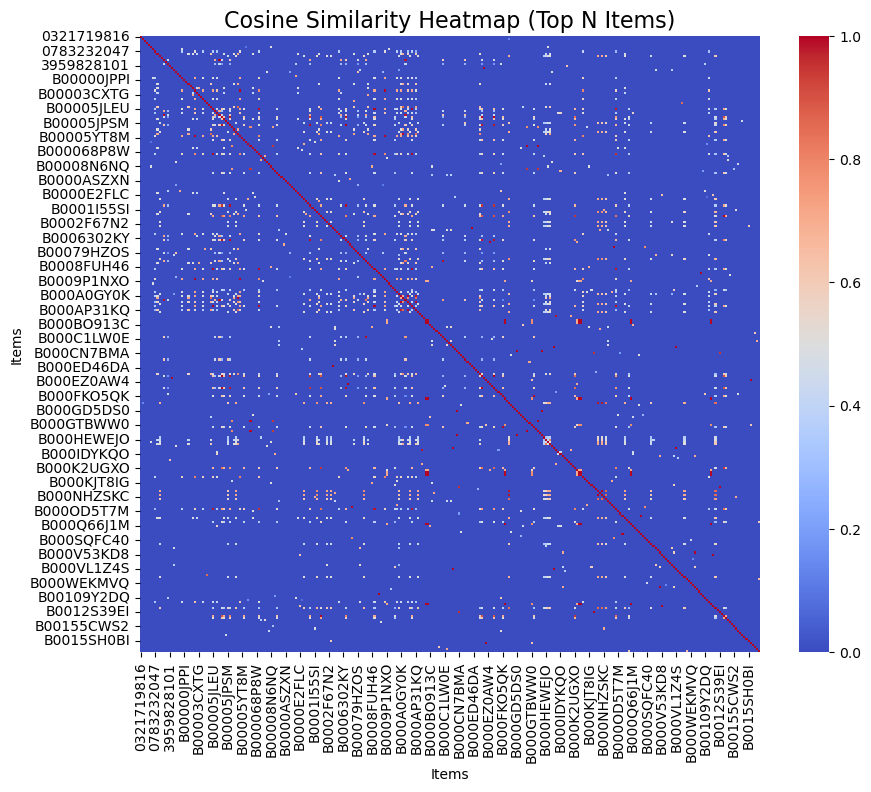

In [140]:
cosine_sim_df = calculate_cosine_similarity(review_df)
visualize_cosine_similarity(cosine_sim_df, top_n=300)

실제 시나리오

1. 카테고리 입력
2. 해당 카테고리 인기 상품 5개 추출
3. 5개 상품에 대하여 각각 추천하여 유사도 높은 순으로 정렬

In [141]:
# 입력한 카테고리에서 인기 상품을 추천하는 함수
def CategoryBasedRecommend(review_df, targetCategory, top_n=5):
    
    filtered_df = review_df[review_df["category"] == targetCategory]
    
    if filtered_df.empty:
        print(f"카테고리 '{targetCategory}'에 해당하는 데이터가 없습니다.")
        return pd.DataFrame()

    popular_items = (
        filtered_df.groupby(["parent_asin", "category","product_title"])
        .agg(avg_rating=("rating", "mean"), num_reviews=("user_id", "count"))
        .reset_index()
        .sort_values(by=["num_reviews", "avg_rating"], ascending=[False, False])
    )
    top_items = popular_items.head(top_n)
    return top_items

In [142]:
# 시나리오를 구현한 코드
input_category = "Video_Games"
review_df = preprocess_review(review_path,2,1)
top_items = CategoryBasedRecommend(review_df,input_category)
recommend_result = []
for _, row in top_items.iterrows():
    target_item = row["parent_asin"]
    target_category = row["category"]
    result = recommend_related_items(review_df, target_item)

    for _, recommend_row in result.iterrows():
        recommended_asin = recommend_row["parent_asin"]
        if recommended_asin not in [item["parent_asin"] for item in recommend_result]:
            recommend_result.append({
                "parent_asin": recommended_asin,
                "product_title": recommend_row["product_title"],
                "category": recommend_row["category"],
                "similarity": recommend_row["similarity"]
            })

sorted_recommendations = sorted(recommend_result, key=lambda x: x["similarity"], reverse=True)[:5]

print("Input Category : ",input_category,"\n")

print("Top 5 Recommended Items:")
for item in sorted_recommendations:
    print(f"Parent ASIN: {item['parent_asin']}")
    print(f"Product Title: {item['product_title']}")
    print(f"Category: {item['category']}")
    print(f"Similarity: {item['similarity']:.3f}")
    print("-" * 30)


Input Category :  Video_Games 

Top 5 Recommended Items:
Parent ASIN: B0799Q3DD7
Product Title: Beauty Makeup photo editor
Category: Software
Similarity: 0.594
------------------------------
Parent ASIN: B00HYJR4RC
Product Title: the Ginger People Organic Grated Ginger, 26.5 Ounce (Pack of 6)
Category: Grocery_Gourmet_Food
Similarity: 0.569
------------------------------
Parent ASIN: B08319G5TX
Product Title: JOYTUTUS 12 Volt Refrigerator, 42 Quart / 40L Portable Freezer (-4℉~50℉) With 12/24V DC and 110V AC, Car Fridge With Compressor For Van, Truck, Vehicle, Camping, Road Trip, Outdoor and Home
Category: Car
Similarity: 0.569
------------------------------
Parent ASIN: B00AD1N7DS
Product Title: Mahjong 3D
Category: Software
Similarity: 0.551
------------------------------
Parent ASIN: 0780623223
Product Title: Zero Effect
Category: Movies_TV
Similarity: 0.547
------------------------------
